In [1]:
!pip install -q geopandas
!apt install -q proj-bin libproj-dev libgeos-dev -y
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install -q rasterio

     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 14.7MB 298kB/s 
     |████████████████████████████████| 10.9MB 37.7MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev libproj-dev proj-bin
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 305 kB of archives.
After this operation, 1,706 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 305 kB in 1s (456 kB/s)
Selecting

---
## Notebook 8
# Visualising WORLDCLIM Variables

In [2]:
# Pandas is a package containing additional functions to use data frames in Python
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import warnings
warnings.simplefilter('ignore')
import rasterio
import rasterio.plot
import numpy as np
import seaborn as sns
# These two lines allow the notebook to access the Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# This is the path to the project folder within the Google Drive.
file_path = "/content/drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


This cell contains some code we'll call later to convert between latitude and longitude co-ordinates and co-ordinates in the raster grids.

In [3]:
def convert_xy_to_longlat(grid_x, grid_y):
  lon = ((grid_x / 6) - 180)
  lat = -((grid_y / 6) - 90)
  return (lon, lat)

def convert_longlat_to_xy(lon, lat):
  grid_x = (lon + 180) * 6
  grid_y = (-lat + 90) * 6
  return (grid_x, grid_y)

----
#Exploring WORLDCLIM Data

We need understand more about the WORLDCLIM data so that we can:

* Make hypotheses about how the species distribution data might be determined by climate
* Choose which WORLDCLIM models to proceed with.

The raster data from WORLDCLIM is explained in the ```data_explanation_and_maps.ipynb notebook```.


The code below runs through every possible combination of climate model, SSP, bioclim variable and time period and imports the data grid for that combination.

There are hundreds of combinations in total.

At the moment this code calculates the mean and maximum values in each grid and puts them into a summary table.

Try to edit the code to calculate some other statistics - there are some examples here: https://numpy.org/doc/stable/reference/routines.statistics.html

Running these loops might take a few minutes

In [4]:
models = ['near_present',
          'BCC-CSM2-MR',
         'CNRM-CM6-1',
         'CNRM-ESM2-1',
         'CanESM5',
         'MIROC-ES2L',
         'MIROC6']

scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

time_periods = ['2021-2040', '2041-2060', '2061-2080', '2081-2100']

summary_table = []

present_done = 0
for model in models:
    for scenario in scenarios:
      for time_period in time_periods:
        if model == "near_present" and present_done == 0:
            raster_path = file_path + "climate_data/near_present.tif"
            scenario = "NA"
            time_period = "NA"
            present_done = 1
        elif model != "near_present":
            raster_path = file_path + "/climate_data/" + model + "/" + scenario + "/" + time_period + ".tiff"
        else:
          continue
        raster = rasterio.open(raster_path)
        # convert the data into a matrix
        grid = raster.read()

        # round it to six decimal places
        grid = np.round(grid, 6)

        # replace "-inf" with "nan"
        grid[grid == float('-inf'), ] = float('nan')

        bioclim = pd.read_csv(file_path + "bioclim.tsv", sep="\t")

        bioclim_name = dict(zip(bioclim['variable_number'], bioclim['name']))
        bioclim_min = dict(zip(bioclim['variable_number'], bioclim['minimum']))
        bioclim_max = dict(zip(bioclim['variable_number'], bioclim['maximum']))

        for variable_number in range(1, 20):
          variable_name = bioclim_name[variable_number]

          current_grid = grid[variable_number - 1]
          current_grid = current_grid[0:930, :]
    
          # Convert the current grid into a list
          current_data = current_grid.flatten()
          # remove the NA values
          current_data = current_data[~np.isnan(current_data)]


          #### You probably only need to change things from here onwards

          current_mean = np.mean(current_data)
          current_max = np.max(current_data)

          summary_table.append([model, scenario, time_period, variable_name, current_mean, current_max])

summary_table = pd.DataFrame(summary_table, columns=['Model', 'Scenario', 'Time Period', 'Variable', 'Variable_Mean', 'Variable_Maximum'])
summary_table.to_csv(file_path + "worldclim_data_summary.tsv", sep="\t", index=None)

In [6]:
summary_table

,Model,Scenario,Time Period,Variable,Variable_Mean,Variable_Maximum
0,near_present,NA,NA,Annual_Mean_Temperature,8.355879,30.987640
1,near_present,NA,NA,Mean_Diurnal_Range_(Mean_of_monthly_(max_temp_...,10.852686,21.147543
2,near_present,NA,NA,Isothermality_(BIO2/BIO7)_(×100),38.750660,100.000000
3,near_present,NA,NA,Temperature_Seasonality_(standard_deviation_×100),845.268127,2363.845947
4,near_present,NA,NA,Max_Temperature_of_Warmest_Month,25.620008,48.082748
...,...,...,...,...,...,...
1838,MIROC6,ssp585,2081-2100,Precipitation_Seasonality_(Coefficient_of_Vari...,61.305786,237.956345
1839,MIROC6,ssp585,2081-2100,Precipitation_of_Wettest_Quarter,332.394836,5066.333496
1840,MIROC6,ssp585,2081-2100,Precipitation_of_Driest_Quarter,78.372330,1696.687500
1841,MIROC6,ssp585,2081-2100,Precipitation_of_Warmest_Quarter,211.771774,5066.333496


This code loops through every model and makes a small bar chart showing the four different SSPs for each time period of for each model for a specific variable.

You can adapt the code for different variables.

The best variables to plot are those which we think are most likely to affect species distribution.

These are likely to include:
* 1 - Annual_Mean_Temperature
* 4 - Temperature_Seasonality_(standard_deviation_×100)	
* 5 - Max_Temperature_of_Warmest_Month
* 6 - Min_Temperature_of_Coldest_Month
* 12 - Annual_Precipitation
* 13 - Precipitation_of_Wettest_Month
* 14 - Precipitation_of_Driest_Month
* 15 - Precipitation_Seasonality

Annual_Mean_Temperature


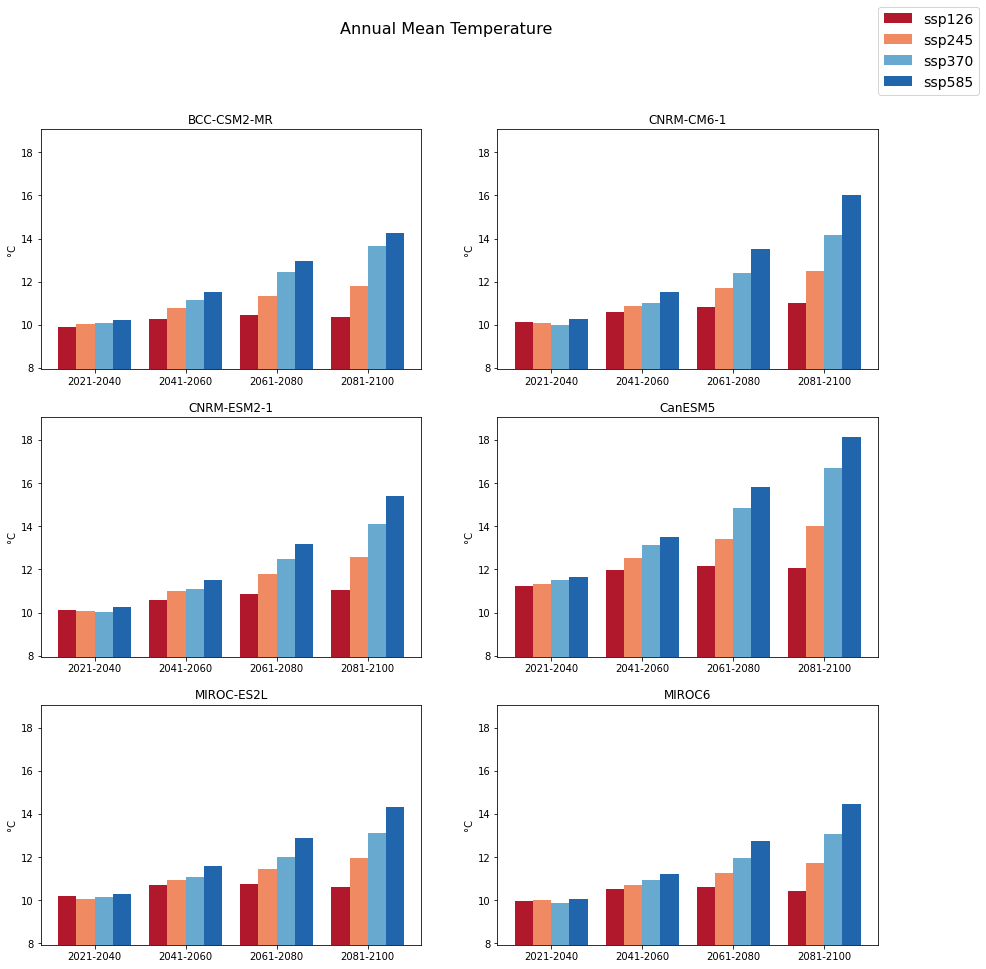

In [22]:
i = 1
bioclim_variable_number = 1
column_to_plot = 'Variable_Mean'

scenario_colours = ['#b2182b', '#ef8a62', '#67a9cf', '#2166ac']

bioclim_variable_to_plot = bioclim_name[bioclim_variable_number]
print (bioclim_variable_to_plot)
f = plt.figure(figsize=(15, 15))

for model in models[1:]:
  # add a new plot to a 3 x 2 grid
  a = f.add_subplot(3, 2, i)

  # select just the rows with this model
  model_table = summary_table[summary_table['Model'] == model]

  # select just the rows of the model table with this variable
  model_plus_variable = model_table[model_table['Variable'] == bioclim_variable_to_plot]

  # choose where to put the bars on the x axis
  barWidth = (0.8 / 4)
  r1 = np.arange(1, 5)
  r2 = [x + barWidth for x in r1]
  r3 = [x + barWidth for x in r2]
  r4 = [x + barWidth for x in r3]

  # plot the mean values for each SSP
  a = plt.bar(r1, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp126'],
          width=barWidth, color=scenario_colours[0])
  b = plt.bar(r2, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp245'],
          width=barWidth, color=scenario_colours[1])
  c = plt.bar(r3, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp370'],
          width=barWidth, color=scenario_colours[2])
  d = plt.bar(r4, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp585'],
          width=barWidth, color=scenario_colours[3])
  
  # add markers to the x axis
  plt.xticks(np.arange(1.3, 5.3), labels=model_plus_variable['Time Period'])

  # set the y axis limits to be the same on each plot - so they are
  # easier to compare
  ymin = min(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot])
  ymin = ymin - (ymin * 0.05)
  ymax = max(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot]) * 1.05
  plt.ylim(ymin, ymax)


  # add a title
  plt.title(model)
  plt.ylabel('°C')
  i += 1

# add a big title to the whole plot
f.suptitle(bioclim_variable_to_plot.replace("_", " "), fontsize=16)

# add a legend
f.legend([a, b, c, d], scenarios, fontsize=14)

f.savefig(file_path + "/worldclim_plots/" + bioclim_variable_to_plot + "_" + column_to_plot  + ".png", dpi=300, bbox_inches='tight')

In [21]:
del min

Temperature_Seasonality_(standard_deviation_×100)


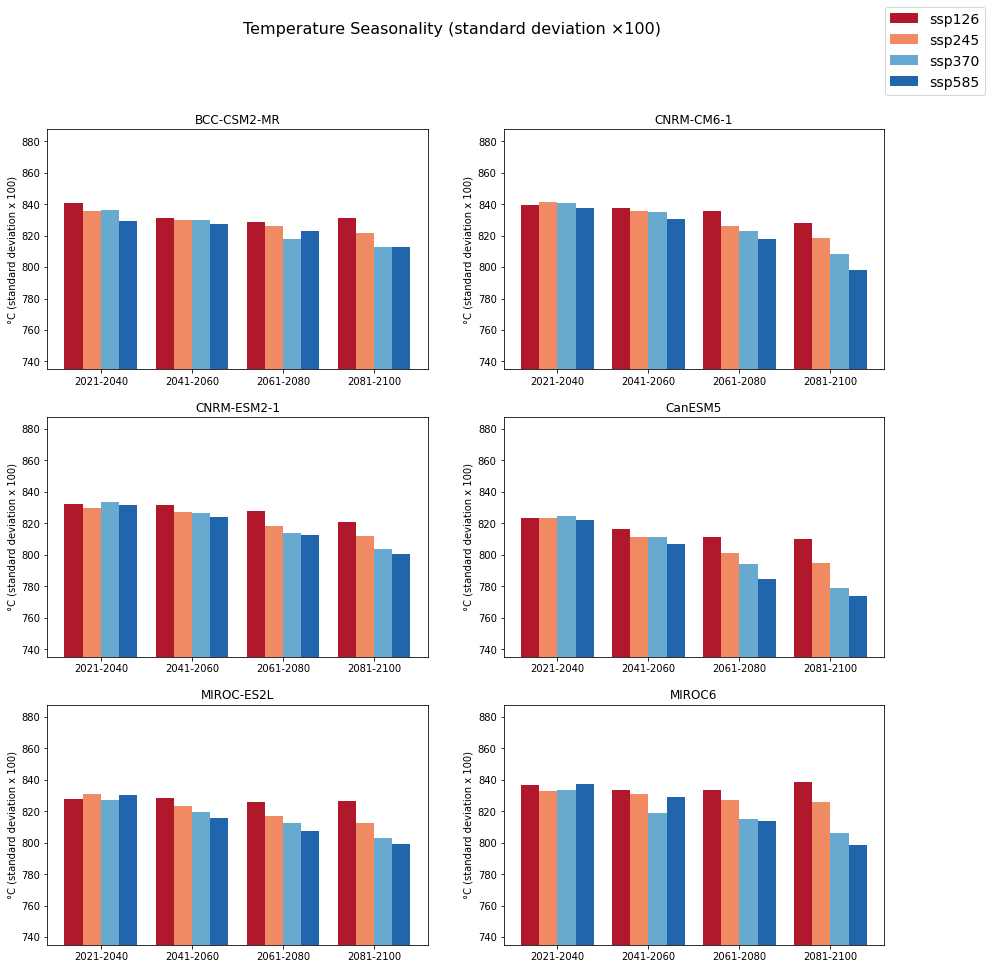

In [24]:
i = 1
bioclim_variable_number = 4
column_to_plot = 'Variable_Mean'

scenario_colours = ['#b2182b', '#ef8a62', '#67a9cf', '#2166ac']

bioclim_variable_to_plot = bioclim_name[bioclim_variable_number]
print (bioclim_variable_to_plot)
f = plt.figure(figsize=(15, 15))

for model in models[1:]:
  # add a new plot to a 3 x 2 grid
  a = f.add_subplot(3, 2, i)

  # select just the rows with this model
  model_table = summary_table[summary_table['Model'] == model]

  # select just the rows of the model table with this variable
  model_plus_variable = model_table[model_table['Variable'] == bioclim_variable_to_plot]

  # choose where to put the bars on the x axis
  barWidth = (0.8 / 4)
  r1 = np.arange(1, 5)
  r2 = [x + barWidth for x in r1]
  r3 = [x + barWidth for x in r2]
  r4 = [x + barWidth for x in r3]

  # plot the mean values for each SSP
  a = plt.bar(r1, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp126'],
          width=barWidth, color=scenario_colours[0])
  b = plt.bar(r2, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp245'],
          width=barWidth, color=scenario_colours[1])
  c = plt.bar(r3, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp370'],
          width=barWidth, color=scenario_colours[2])
  d = plt.bar(r4, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp585'],
          width=barWidth, color=scenario_colours[3])
  
  # add markers to the x axis
  plt.xticks(np.arange(1.3, 5.3), labels=model_plus_variable['Time Period'])

  # set the y axis limits to be the same on each plot - so they are
  # easier to compare
  ymin = min(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot])
  ymin = ymin - (ymin * 0.05)
  ymax = max(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot]) * 1.05
  plt.ylim(ymin, ymax)

  # add a title
  plt.title(model)
  plt.ylabel('°C (standard deviation x 100)')
  i += 1

# add a big title to the whole plot
f.suptitle(bioclim_variable_to_plot.replace("_", " "), fontsize=16)

# add a legend
f.legend([a, b, c, d], scenarios, fontsize=14)

f.savefig(file_path + "/worldclim_plots/" + bioclim_variable_to_plot + "_" + column_to_plot  + ".png", dpi=300, bbox_inches='tight')

Max_Temperature_of_Warmest_Month


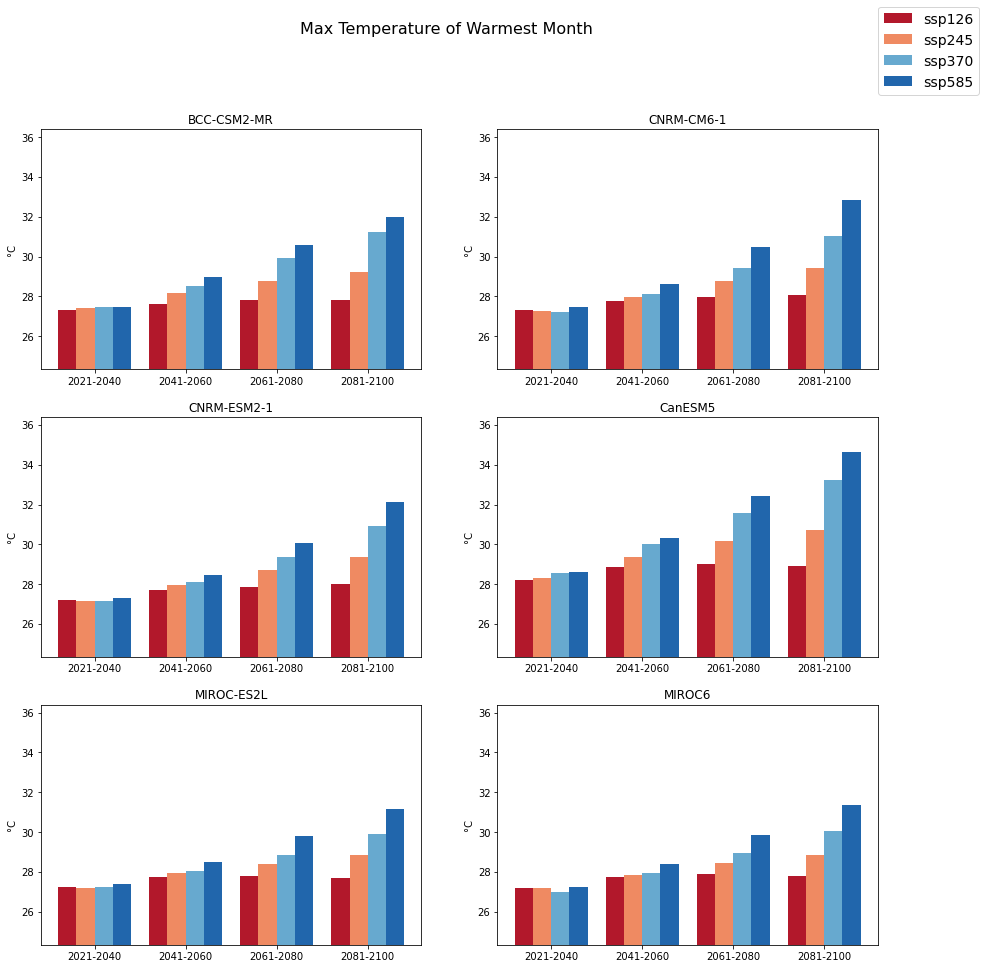

In [25]:
i = 1
bioclim_variable_number = 5
column_to_plot = 'Variable_Mean'

scenario_colours = ['#b2182b', '#ef8a62', '#67a9cf', '#2166ac']

bioclim_variable_to_plot = bioclim_name[bioclim_variable_number]
print (bioclim_variable_to_plot)
f = plt.figure(figsize=(15, 15))

for model in models[1:]:
  # add a new plot to a 3 x 2 grid
  a = f.add_subplot(3, 2, i)

  # select just the rows with this model
  model_table = summary_table[summary_table['Model'] == model]

  # select just the rows of the model table with this variable
  model_plus_variable = model_table[model_table['Variable'] == bioclim_variable_to_plot]

  # choose where to put the bars on the x axis
  barWidth = (0.8 / 4)
  r1 = np.arange(1, 5)
  r2 = [x + barWidth for x in r1]
  r3 = [x + barWidth for x in r2]
  r4 = [x + barWidth for x in r3]

  # plot the mean values for each SSP
  a = plt.bar(r1, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp126'],
          width=barWidth, color=scenario_colours[0])
  b = plt.bar(r2, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp245'],
          width=barWidth, color=scenario_colours[1])
  c = plt.bar(r3, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp370'],
          width=barWidth, color=scenario_colours[2])
  d = plt.bar(r4, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp585'],
          width=barWidth, color=scenario_colours[3])
  
  # add markers to the x axis
  plt.xticks(np.arange(1.3, 5.3), labels=model_plus_variable['Time Period'])

  # set the y axis limits to be the same on each plot - so they are
  # easier to compare
  ymin = min(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot])
  ymin = ymin - (ymin * 0.05)
  ymax = max(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot]) * 1.05
  plt.ylim(ymin, ymax)

  # add a title
  plt.title(model)
  plt.ylabel('°C')
  i += 1

# add a big title to the whole plot
f.suptitle(bioclim_variable_to_plot.replace("_", " "), fontsize=16)

# add a legend
f.legend([a, b, c, d], scenarios, fontsize=14)


f.savefig(file_path + "/worldclim_plots/" + bioclim_variable_to_plot + "_" + column_to_plot  + ".png", dpi=300, bbox_inches='tight')

Min_Temperature_of_Coldest_Month


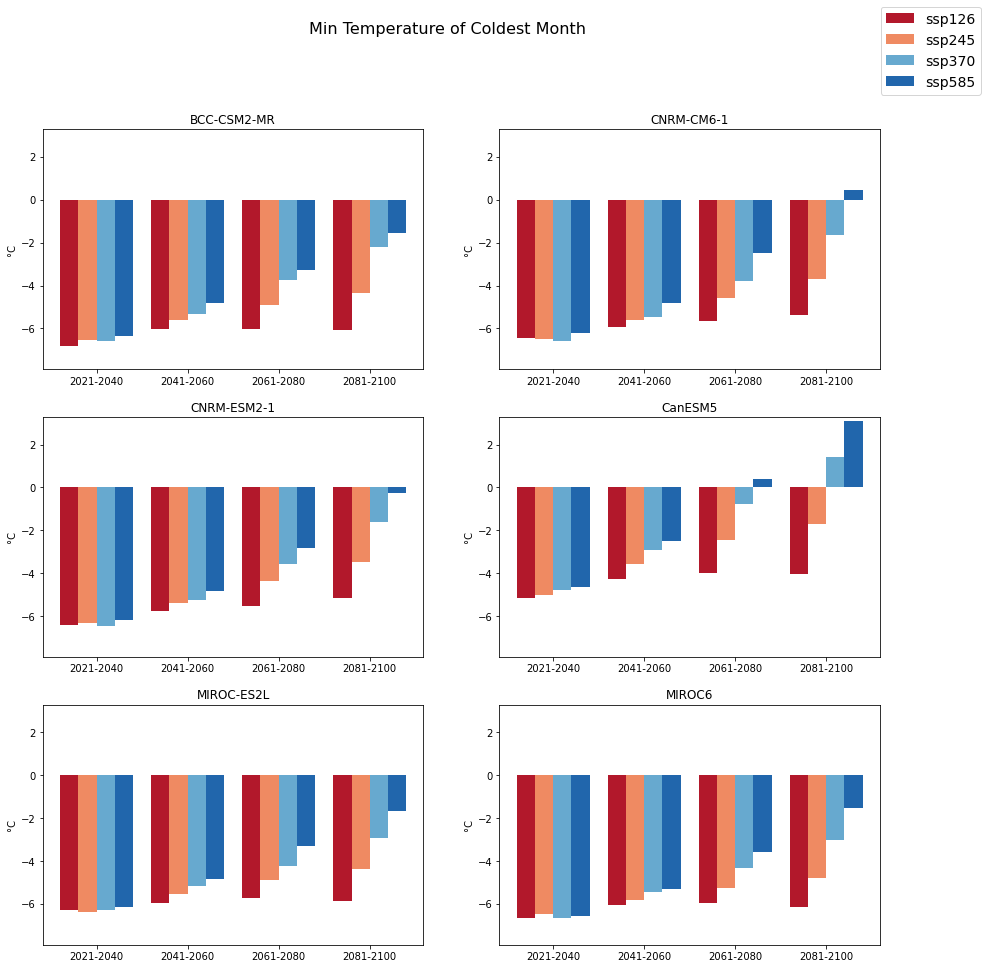

In [26]:
i = 1
bioclim_variable_number = 6
column_to_plot = 'Variable_Mean'

scenario_colours = ['#b2182b', '#ef8a62', '#67a9cf', '#2166ac']

bioclim_variable_to_plot = bioclim_name[bioclim_variable_number]
print (bioclim_variable_to_plot)
f = plt.figure(figsize=(15, 15))

for model in models[1:]:
  # add a new plot to a 3 x 2 grid
  a = f.add_subplot(3, 2, i)

  # select just the rows with this model
  model_table = summary_table[summary_table['Model'] == model]

  # select just the rows of the model table with this variable
  model_plus_variable = model_table[model_table['Variable'] == bioclim_variable_to_plot]

  # choose where to put the bars on the x axis
  barWidth = (0.8 / 4)
  r1 = np.arange(1, 5)
  r2 = [x + barWidth for x in r1]
  r3 = [x + barWidth for x in r2]
  r4 = [x + barWidth for x in r3]

  # plot the mean values for each SSP
  a = plt.bar(r1, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp126'],
          width=barWidth, color=scenario_colours[0])
  b = plt.bar(r2, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp245'],
          width=barWidth, color=scenario_colours[1])
  c = plt.bar(r3, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp370'],
          width=barWidth, color=scenario_colours[2])
  d = plt.bar(r4, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp585'],
          width=barWidth, color=scenario_colours[3])
  
  # add markers to the x axis
  plt.xticks(np.arange(1.3, 5.3), labels=model_plus_variable['Time Period'])

  # set the y axis limits to be the same on each plot - so they are
  # easier to compare
  ymin = min(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot])
  ymin = ymin - (ymin * 0.05)
  ymax = max(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot]) * 1.05
  plt.ylim(ymin, ymax)

  plt.title(model)
  plt.ylabel('°C')
  i += 1

# add a big title to the whole plot
f.suptitle(bioclim_variable_to_plot.replace("_", " "), fontsize=16)

# add a legend
f.legend([a, b, c, d], scenarios, fontsize=14)

f.savefig(file_path + "/worldclim_plots/" + bioclim_variable_to_plot + "_" + column_to_plot  + ".png", dpi=300, bbox_inches='tight')

Annual_Precipitation


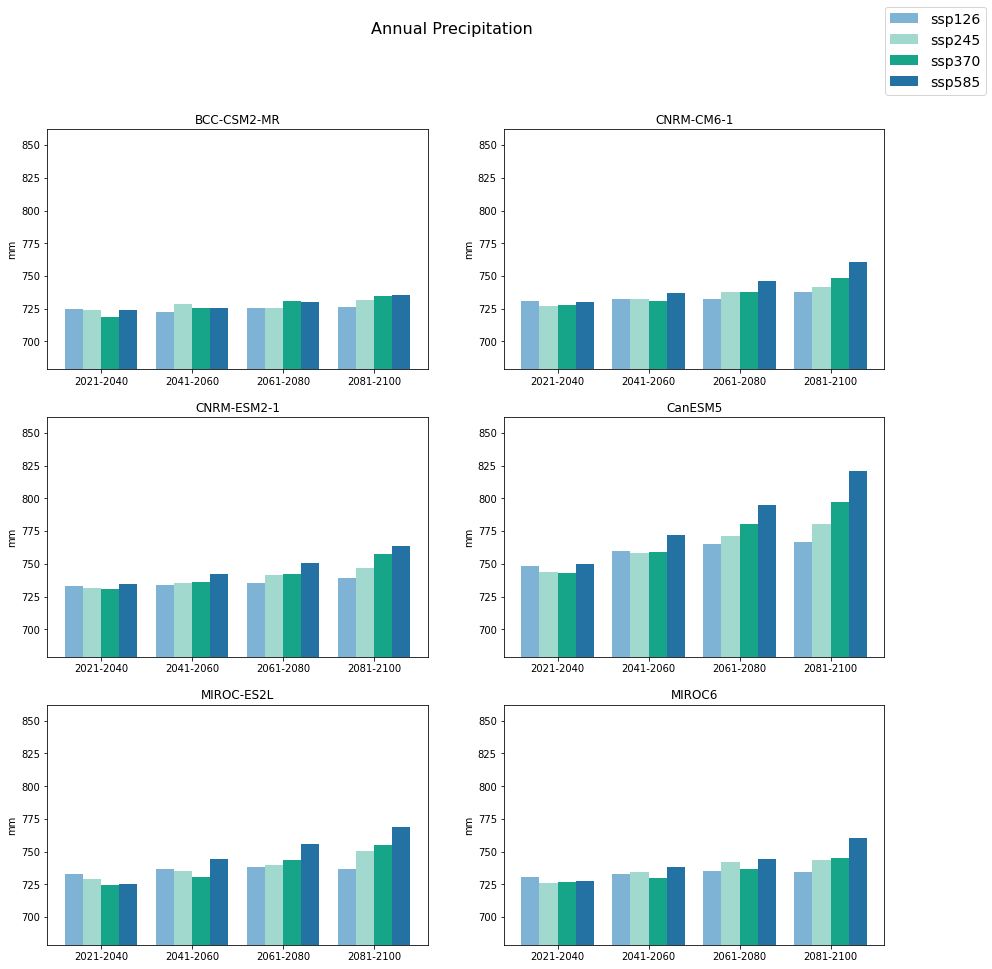

In [29]:
i = 1
bioclim_variable_number = 12
column_to_plot = 'Variable_Mean'

scenario_colours = ['#7fb3d5', '#a2d9ce', '#17a589', '#2471a3']

bioclim_variable_to_plot = bioclim_name[bioclim_variable_number]
print (bioclim_variable_to_plot)
f = plt.figure(figsize=(15, 15))

for model in models[1:]:
  # add a new plot to a 3 x 2 grid
  a = f.add_subplot(3, 2, i)

  # select just the rows with this model
  model_table = summary_table[summary_table['Model'] == model]

  # select just the rows of the model table with this variable
  model_plus_variable = model_table[model_table['Variable'] == bioclim_variable_to_plot]

  # choose where to put the bars on the x axis
  barWidth = (0.8 / 4)
  r1 = np.arange(1, 5)
  r2 = [x + barWidth for x in r1]
  r3 = [x + barWidth for x in r2]
  r4 = [x + barWidth for x in r3]

  # plot the mean values for each SSP
  a = plt.bar(r1, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp126'],
          width=barWidth, color=scenario_colours[0])
  b = plt.bar(r2, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp245'],
          width=barWidth, color=scenario_colours[1])
  c = plt.bar(r3, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp370'],
          width=barWidth, color=scenario_colours[2])
  d = plt.bar(r4, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp585'],
          width=barWidth, color=scenario_colours[3])
  
  # add markers to the x axis
  plt.xticks(np.arange(1.3, 5.3), labels=model_plus_variable['Time Period'])

  # set the y axis limits to be the same on each plot - so they are
  # easier to compare
  ymin = min(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot])
  ymin = ymin - (ymin * 0.05)
  ymax = max(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot]) * 1.05
  plt.ylim(ymin, ymax)

  # add a title
  plt.title(model)
  plt.ylabel('mm')
  i += 1

# add a big title to the whole plot
f.suptitle(bioclim_variable_to_plot.replace("_", " "), fontsize=16)

# add a legend
f.legend([a, b, c, d], scenarios, fontsize=14)

f.savefig(file_path + "/worldclim_plots/" + bioclim_variable_to_plot + "_" + column_to_plot  + ".png", dpi=300, bbox_inches='tight')

Precipitation_of_Wettest_Month


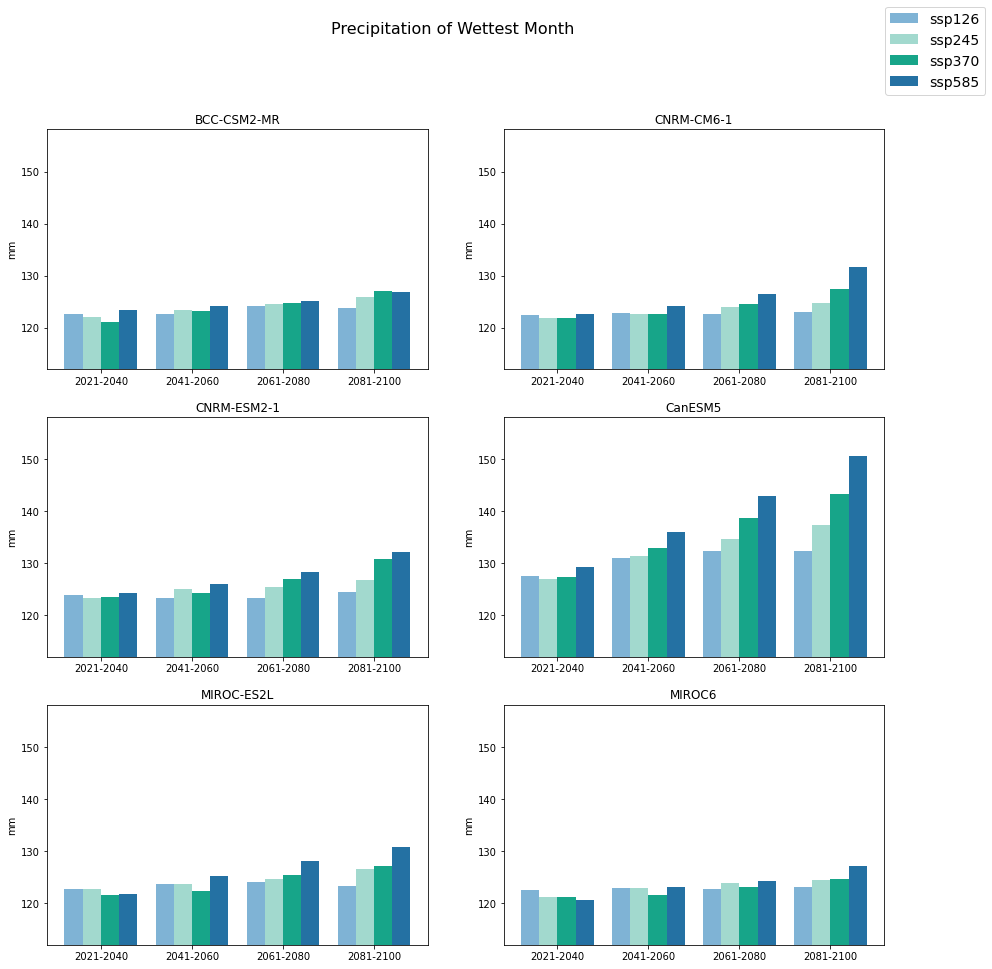

In [30]:
i = 1
bioclim_variable_number = 13
column_to_plot = 'Variable_Mean'

scenario_colours = ['#7fb3d5', '#a2d9ce', '#17a589', '#2471a3']

bioclim_variable_to_plot = bioclim_name[bioclim_variable_number]
print (bioclim_variable_to_plot)
f = plt.figure(figsize=(15, 15))

for model in models[1:]:
  # add a new plot to a 3 x 2 grid
  a = f.add_subplot(3, 2, i)

  # select just the rows with this model
  model_table = summary_table[summary_table['Model'] == model]

  # select just the rows of the model table with this variable
  model_plus_variable = model_table[model_table['Variable'] == bioclim_variable_to_plot]

  # choose where to put the bars on the x axis
  barWidth = (0.8 / 4)
  r1 = np.arange(1, 5)
  r2 = [x + barWidth for x in r1]
  r3 = [x + barWidth for x in r2]
  r4 = [x + barWidth for x in r3]

  # plot the mean values for each SSP
  a = plt.bar(r1, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp126'],
          width=barWidth, color=scenario_colours[0])
  b = plt.bar(r2, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp245'],
          width=barWidth, color=scenario_colours[1])
  c = plt.bar(r3, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp370'],
          width=barWidth, color=scenario_colours[2])
  d = plt.bar(r4, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp585'],
          width=barWidth, color=scenario_colours[3])
  
  # add markers to the x axis
  plt.xticks(np.arange(1.3, 5.3), labels=model_plus_variable['Time Period'])

  # set the y axis limits to be the same on each plot - so they are
  # easier to compare
  ymin = min(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot])
  ymin = ymin - (ymin * 0.05)
  ymax = max(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot]) * 1.05
  plt.ylim(ymin, ymax)

  # add a title
  plt.title(model)
  plt.ylabel('mm')
  i += 1

# add a big title to the whole plot
f.suptitle(bioclim_variable_to_plot.replace("_", " "), fontsize=16)

# add a legend
f.legend([a, b, c, d], scenarios, fontsize=14)

f.savefig(file_path + "/worldclim_plots/" + bioclim_variable_to_plot + "_" + column_to_plot  + ".png", dpi=300, bbox_inches='tight')

Precipitation_of_Driest_Month


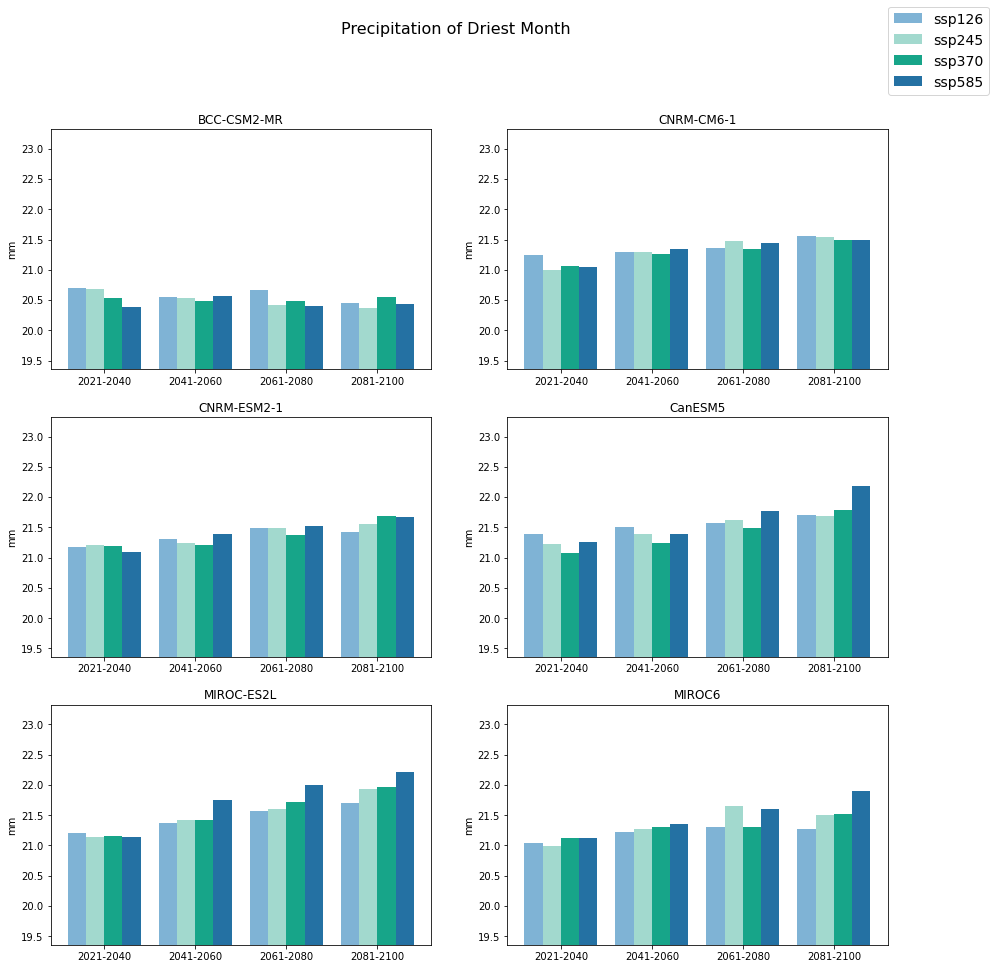

In [31]:
i = 1
bioclim_variable_number = 14
column_to_plot = 'Variable_Mean'

scenario_colours = ['#7fb3d5', '#a2d9ce', '#17a589', '#2471a3']

bioclim_variable_to_plot = bioclim_name[bioclim_variable_number]
print (bioclim_variable_to_plot)
f = plt.figure(figsize=(15, 15))

for model in models[1:]:
  # add a new plot to a 3 x 2 grid
  a = f.add_subplot(3, 2, i)

  # select just the rows with this model
  model_table = summary_table[summary_table['Model'] == model]

  # select just the rows of the model table with this variable
  model_plus_variable = model_table[model_table['Variable'] == bioclim_variable_to_plot]

  # choose where to put the bars on the x axis
  barWidth = (0.8 / 4)
  r1 = np.arange(1, 5)
  r2 = [x + barWidth for x in r1]
  r3 = [x + barWidth for x in r2]
  r4 = [x + barWidth for x in r3]

  # plot the mean values for each SSP
  a = plt.bar(r1, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp126'],
          width=barWidth, color=scenario_colours[0])
  b = plt.bar(r2, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp245'],
          width=barWidth, color=scenario_colours[1])
  c = plt.bar(r3, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp370'],
          width=barWidth, color=scenario_colours[2])
  d = plt.bar(r4, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp585'],
          width=barWidth, color=scenario_colours[3])
  
  # add markers to the x axis
  plt.xticks(np.arange(1.3, 5.3), labels=model_plus_variable['Time Period'])

  # set the y axis limits to be the same on each plot - so they are
  # easier to compare
  ymin = min(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot])
  ymin = ymin - (ymin * 0.05)
  ymax = max(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot]) * 1.05
  plt.ylim(ymin, ymax)

  # add a title
  plt.title(model)
  plt.ylabel('mm')
  i += 1

# add a big title to the whole plot
f.suptitle(bioclim_variable_to_plot.replace("_", " "), fontsize=16)

# add a legend
f.legend([a, b, c, d], scenarios, fontsize=14)

f.savefig(file_path + "/worldclim_plots/" + bioclim_variable_to_plot + "_" + column_to_plot  + ".png", dpi=300, bbox_inches='tight')

Precipitation_Seasonality_(Coefficient_of_Variation)


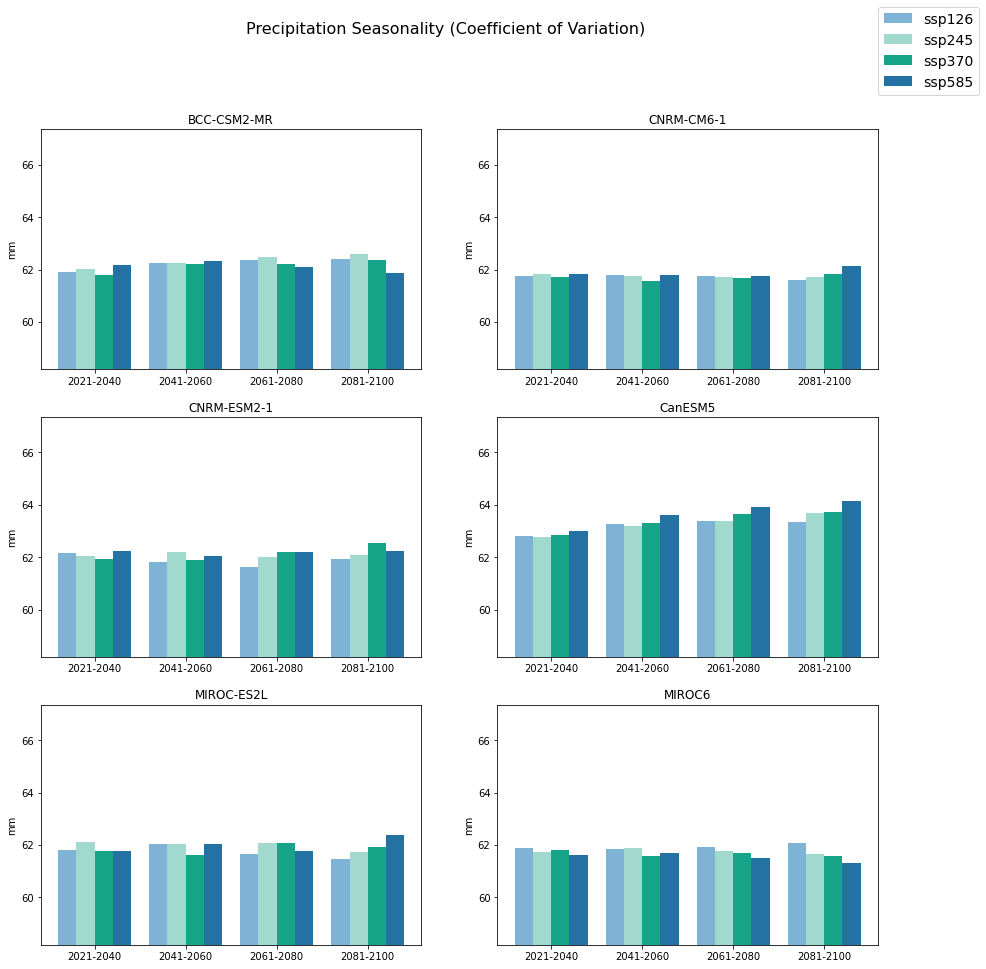

In [32]:
i = 1
bioclim_variable_number = 15
column_to_plot = 'Variable_Mean'

scenario_colours = ['#7fb3d5', '#a2d9ce', '#17a589', '#2471a3']

bioclim_variable_to_plot = bioclim_name[bioclim_variable_number]
print (bioclim_variable_to_plot)
f = plt.figure(figsize=(15, 15))

for model in models[1:]:
  # add a new plot to a 3 x 2 grid
  a = f.add_subplot(3, 2, i)

  # select just the rows with this model
  model_table = summary_table[summary_table['Model'] == model]

  # select just the rows of the model table with this variable
  model_plus_variable = model_table[model_table['Variable'] == bioclim_variable_to_plot]

  # choose where to put the bars on the x axis
  barWidth = (0.8 / 4)
  r1 = np.arange(1, 5)
  r2 = [x + barWidth for x in r1]
  r3 = [x + barWidth for x in r2]
  r4 = [x + barWidth for x in r3]

  # plot the mean values for each SSP
  a = plt.bar(r1, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp126'],
          width=barWidth, color=scenario_colours[0])
  b = plt.bar(r2, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp245'],
          width=barWidth, color=scenario_colours[1])
  c = plt.bar(r3, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp370'],
          width=barWidth, color=scenario_colours[2])
  d = plt.bar(r4, model_plus_variable[column_to_plot][model_plus_variable['Scenario'] == 'ssp585'],
          width=barWidth, color=scenario_colours[3])
  
  # add markers to the x axis
  plt.xticks(np.arange(1.3, 5.3), labels=model_plus_variable['Time Period'])

  # set the y axis limits to be the same on each plot - so they are
  # easier to compare
  ymin = min(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot])
  ymin = ymin - (ymin * 0.05)
  ymax = max(summary_table[summary_table['Variable'] == bioclim_variable_to_plot][column_to_plot]) * 1.05
  plt.ylim(ymin, ymax)

  # add a title
  plt.title(model)
  plt.ylabel('mm')
  i += 1

# add a big title to the whole plot
f.suptitle(bioclim_variable_to_plot.replace("_", " "), fontsize=16)

# add a legend
f.legend([a, b, c, d], scenarios, fontsize=14)

f.savefig(file_path + "/worldclim_plots/" + bioclim_variable_to_plot + "_" + column_to_plot  + ".png", dpi=300, bbox_inches='tight')